In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import awkward1 as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection
from klepto.archives import dir_archive

import numpy as np

from processor.forward_jet import *


In [8]:
# load the basic filesets and choose what samples we actually want to load

from Tools.samples import fileset_2018
from processor.default_accumulators import variations, desired_output


In [9]:
%%time
overwrite = False
year = 2018

# load the config and the cache
cfg = loadConfig()

cacheName = 'forward'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

'''
fileset = {
    'tW_scattering': glob.glob("/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/*.root"),
    'topW_v2': glob.glob("/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/*.root"),
    
}
'''


fileset = {
    #'tW_scattering': fileset_2018['tW_scattering'],
    'topW_v2': fileset_2018['topW_v2'],
    'ttbar': fileset_2018['ttbar2l'], # dilepton ttbar should be enough for this study.
    'MuonEG': fileset_2018['MuonEG'],
    'WW': fileset_2018['WW'],
    'WZ': fileset_2018['WZ'],
    'DY': fileset_2018['DY'],
}


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

#if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
if cfg == cache.get('cfg') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        forwardJetAnalyzer(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

CPU times: user 9.24 ms, sys: 1.23 s, total: 1.24 s
Wall time: 1.24 s


~22s for baseline code


In [11]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['tW_scattering', 'topW_v2']
processes = ['DY', 'ttbar', 'WW', 'WZ', 'MuonEG', 'EGamma', 'DoubleMuon']

# let's use the S/B functionality to get data/MC by defining data (MuonEG) as signal
lines = ['entry']
lines +=   ['filter',
            'lepveto',
            'dilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'OS',
            'N_jet>3',
            'N_central>2',
            'N_btag>0',
            'MET>30',
            'N_fwd>0',
            ]


df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4,
                    # signal='MuonEG'
                    )
df

,DY,ttbar,WW,WZ,MuonEG,EGamma,DoubleMuon
entry,85610000.0 +/- 20000.0,2889000.0 +/- 1000.0,411900.0 +/- 200.0,234800.0 +/- 100.0,62830000.0 +/- 10000.0,162500000.0 +/- 0.0,109900000.0 +/- 0.0
filter,85590000.0 +/- 20000.0,2887000.0 +/- 1000.0,411800.0 +/- 200.0,234700.0 +/- 100.0,62790000.0 +/- 10000.0,162300000.0 +/- 0.0,109900000.0 +/- 0.0
lepveto,76780000.0 +/- 20000.0,1795000.0 +/- 0.0,151400.0 +/- 100.0,109100.0 +/- 100.0,6090000.0 +/- 2000.0,38030000.0 +/- 10000.0,51980000.0 +/- 10000.0
dilep,43650000.0 +/- 10000.0,696000.0 +/- 200.0,64950.0 +/- 80.0,49950.0 +/- 50.0,896800.0 +/- 900.0,7416000.0 +/- 3000.0,35430000.0 +/- 10000.0
p_T(lep0)>25,43130000.0 +/- 10000.0,686100.0 +/- 200.0,64160.0 +/- 80.0,49390.0 +/- 50.0,875000.0 +/- 900.0,7385000.0 +/- 3000.0,34580000.0 +/- 10000.0
p_T(lep1)>20,42150000.0 +/- 10000.0,620700.0 +/- 200.0,60630.0 +/- 80.0,45750.0 +/- 50.0,776600.0 +/- 900.0,7162000.0 +/- 3000.0,33340000.0 +/- 10000.0
trigger,32720000.0 +/- 10000.0,530800.0 +/- 200.0,50200.0 +/- 70.0,36870.0 +/- 40.0,345000.0 +/- 600.0,6409000.0 +/- 3000.0,25230000.0 +/- 10000.0
OS,32720000.0 +/- 10000.0,530600.0 +/- 200.0,50040.0 +/- 70.0,34740.0 +/- 40.0,341700.0 +/- 600.0,6406000.0 +/- 3000.0,25220000.0 +/- 10000.0
N_jet>3,472700.0 +/- 1300.0,172700.0 +/- 100.0,1446.0 +/- 11.0,5962.0 +/- 16.0,82580.0 +/- 290.0,119900.0 +/- 300.0,459000.0 +/- 700.0
N_central>2,311300.0 +/- 1000.0,152100.0 +/- 100.0,1010.0 +/- 9.0,4840.0 +/- 15.0,73300.0 +/- 270.0,91690.0 +/- 300.0,344500.0 +/- 600.0


5.693 v0.2.3 vs 5.693 in v0.2.2 -> good

PU weight looks good, too.


In [12]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False)
df

,DY,ttbar,WW,WZ,MuonEG,EGamma,DoubleMuon
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9998,0.9996,0.9996,0.9993,0.9993,0.9993,0.9996
lepveto,0.8971,0.6216,0.3676,0.4647,0.0970,0.2342,0.4730
dilep,0.5684,0.3877,0.4290,0.4579,0.1472,0.1950,0.6816
p_T(lep0)>25,0.9881,0.9859,0.9879,0.9890,0.9757,0.9958,0.9762
p_T(lep1)>20,0.9774,0.9047,0.9450,0.9261,0.8876,0.9697,0.9639
trigger,0.7762,0.8551,0.8280,0.8059,0.4442,0.8949,0.7567
OS,0.9999,0.9997,0.9968,0.9423,0.9905,0.9995,0.9999
N_jet>3,0.0144,0.3255,0.0289,0.1716,0.2417,0.0187,0.0182
N_central>2,0.6585,0.8807,0.6986,0.8117,0.8876,0.7647,0.7504


/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/:
  files: 478
  nEvents: 478000
  name: ProjectMetis_TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2
  path: /hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/
  split: 207
  sumWeight: 22576.62849550001
  xsec: 0.0478

filter efficiency: 0.482

/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/:
  files: 56
  nEvents: 54200
  name: tW_scattering_nanoAOD
  path: /hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/
  split: 56
  sumWeight: 2622.728769570001
  xsec: 0.0478
  
filter efficiency: 0.46

**I need to check where these two samples depart from each other**

Most of the selections are slightly less efficient on the new sample, but they agree within 2 sigma.
In the end it is

7.834 +/- 0.674 (old) vs 7.096 +/- 0.216 (new)

in the OS ttbar selection.

The PU distribution looks a bit odd in the old sample, but otherwise things look good.
(PU mixing has been updated in the new sample to include a larger number of neutrino gun files)


In [74]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import *

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v2': 'top-W scat.',
    'WW': 'WW',
    'WZ': 'WZ',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
    'MuonEG': 'Observation',
    'EGamma': 'Observation',
    'DoubleMuon': 'Observation',
}

my_colors = {
    'topW_v2': '#FF595E',
    'WW': '#34623F',
    'WZ': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',
    'MuonEG': '#000000',
    'EGamma': '#000000',
    'DoubleMuon': '#000000',
}

['DY', 'WZ', 'WW', 'ttbar', 'topW_v2']
Data: 75383.0 MC: 71785.66


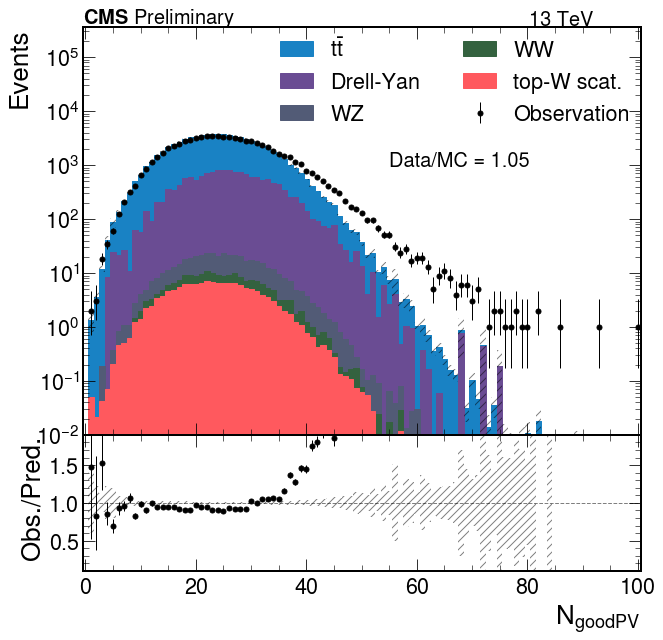

In [77]:
makePlot(output, 'PV_npvsGood', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=None,
         log=True, normalize=True, axis_label=r'$N_{good PV}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v2', 'WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

Data: 75383.0 MC: 71785.66


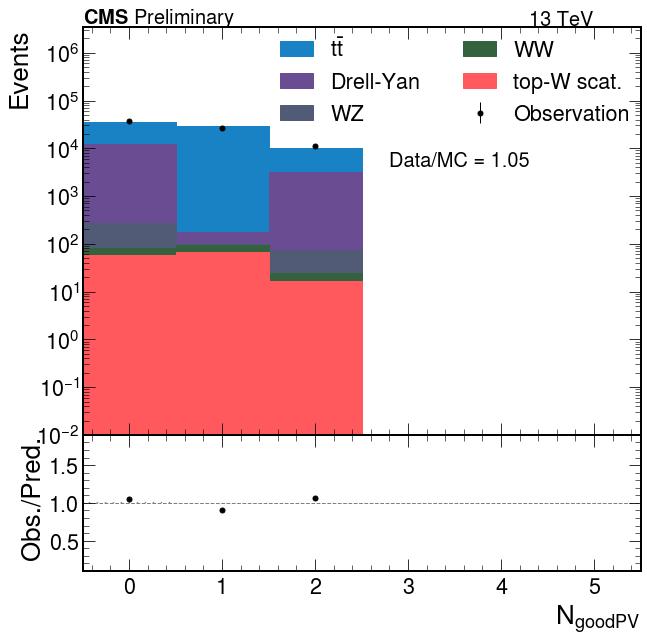

In [83]:
makePlot(output, 'N_ele', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red,
         log=True, normalize=True, axis_label=r'$N_{good PV}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v2', 'WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

['DY', 'WZ', 'WW', 'ttbar', 'topW_v2']
Data: 75383.0 MC: 71785.66


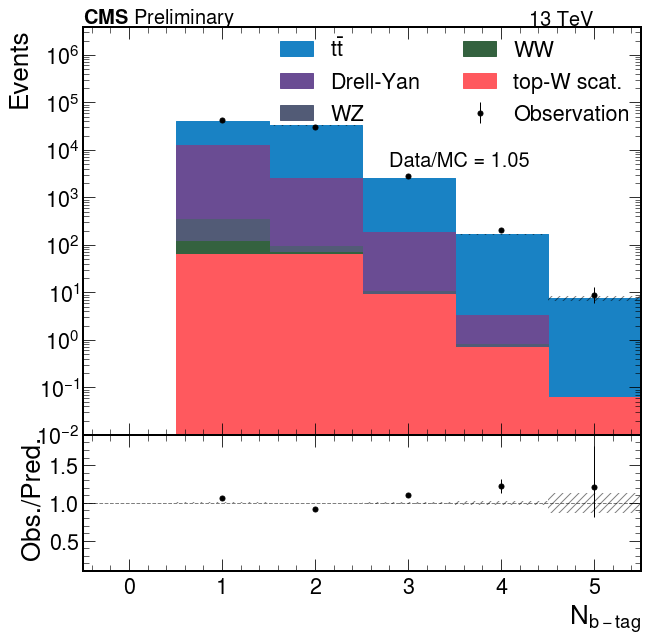

In [79]:
makePlot(output, 'N_b', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red,
         log=True, normalize=True, axis_label=r'$N_{b-tag}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v2', 'WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

['DY', 'WZ', 'WW', 'ttbar', 'topW_v2']
Data: 75383.0 MC: 71785.66


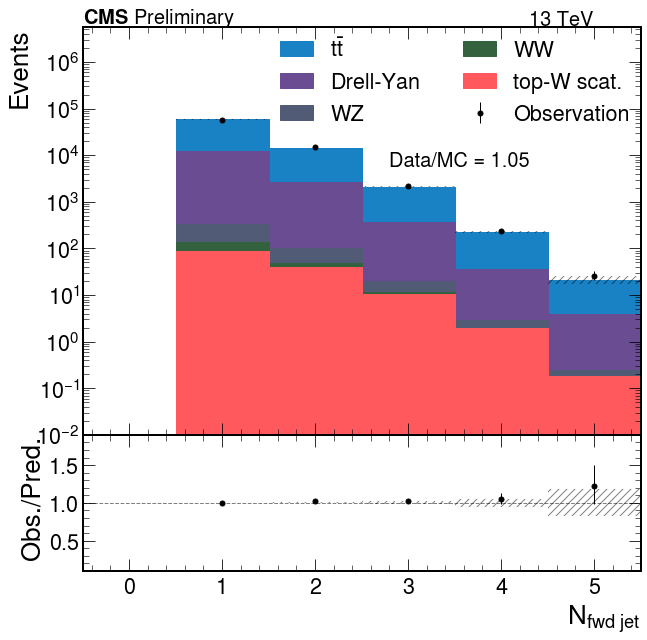

In [80]:
makePlot(output, 'N_fwd', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red,
         log=True, normalize=True, axis_label=r'$N_{fwd\ jet}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v2', 'WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

['DY', 'WZ', 'WW', 'ttbar', 'topW_v2']
Data: 75383.0 MC: 71785.66


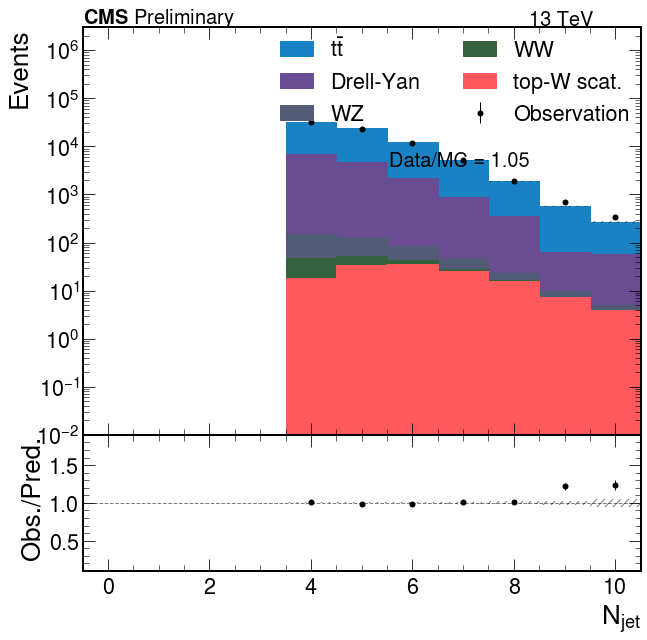

In [81]:
makePlot(output, 'N_jet', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins,
         log=True, normalize=True, axis_label=r'$N_{jet}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v2', 'WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

['DY', 'WZ', 'WW', 'ttbar', 'topW_v2']
Data: 75383.0 MC: 71785.66


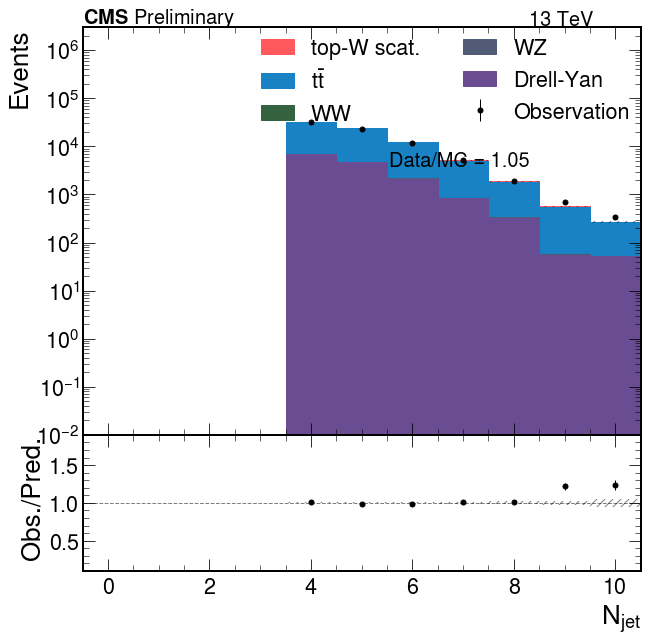

In [82]:
makePlot(output, 'N_jet', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins,
         log=True, normalize=True, axis_label=r'$N_{jet}$',
         new_colors=my_colors, new_labels=my_labels,
         #order=['WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

Data: 75383.0 MC: 71651.67


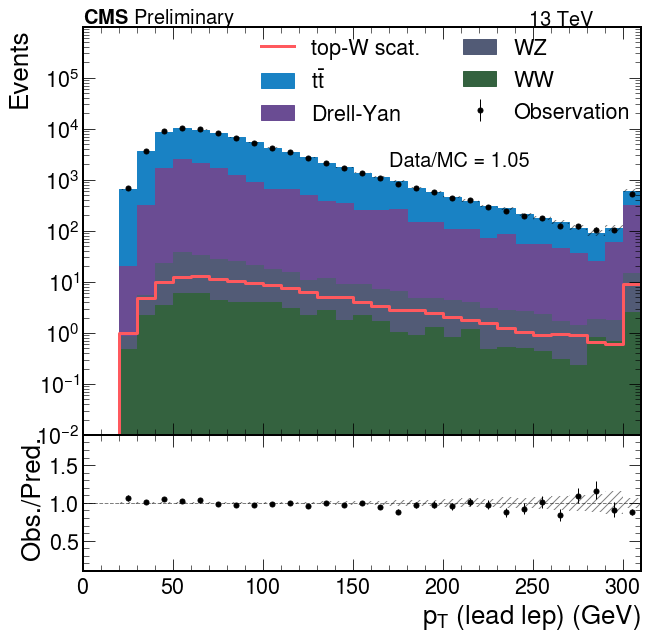

In [86]:
makePlot(output, 'lead_lep', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins,
         log=True, normalize=True, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['WW', 'WZ', 'DY', 'ttbar'],
         signals=['topW_v2'],
         omit=[],
        )

Data: 75382.0 MC: 71785.35


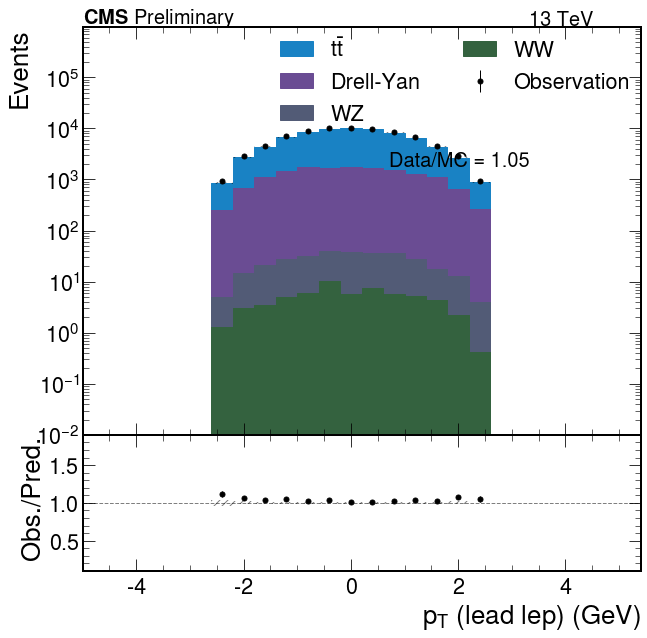

In [58]:
makePlot(output, 'lead_lep', 'eta',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=eta_bins,
         log=True, normalize=True, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

Data: 75383.0 MC: 71785.66


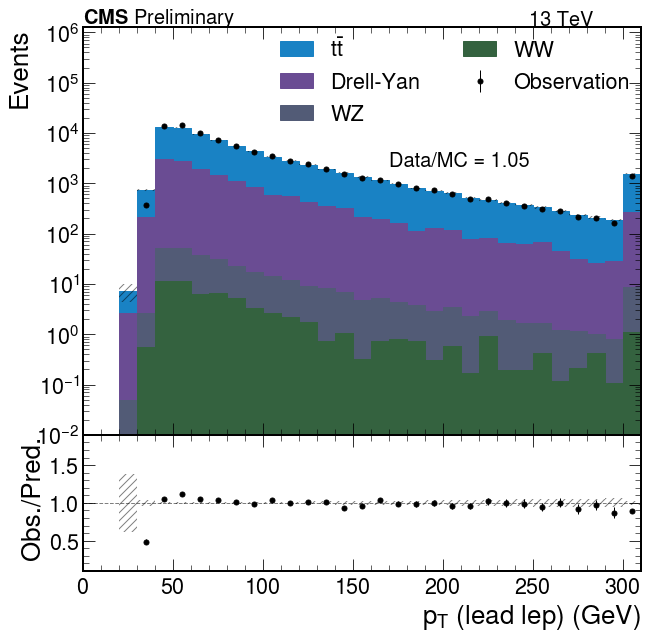

In [56]:
makePlot(output, 'fwd_jet', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins,
         log=True, normalize=True, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

Data: 75383.0 MC: 71785.66


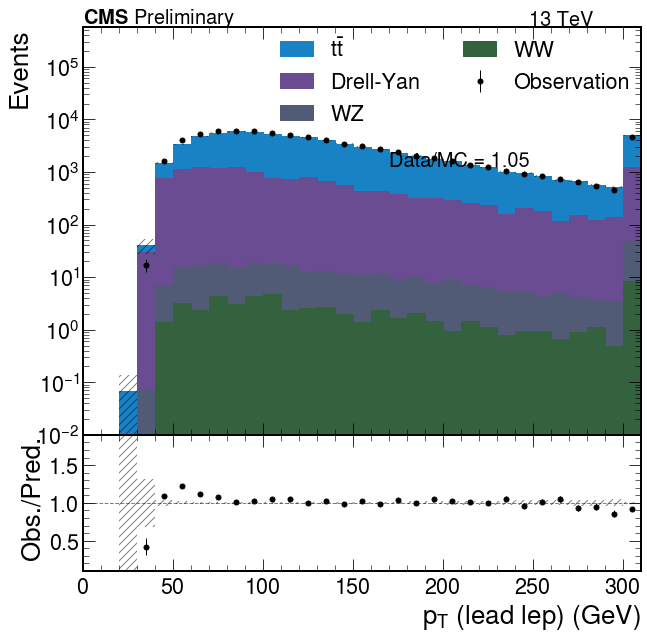

In [57]:
makePlot(output, 'j1', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins,
         log=True, normalize=True, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['WW', 'WZ', 'DY', 'ttbar'],
         omit=[],
        )

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


Data: 0 MC: 356533.26


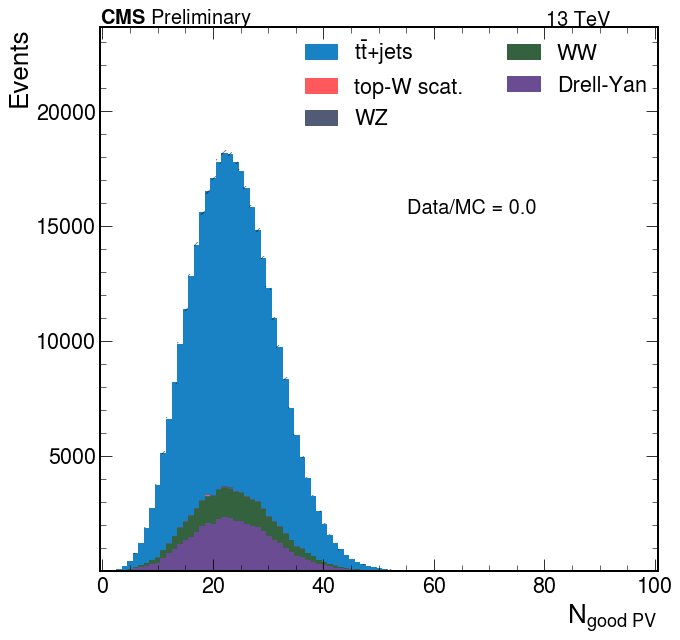

In [8]:
makePlot(output, 'PV_npvsGood', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label=r'$N_{good\ PV}$',
        )

Data: 349165.0 MC: 356533.26


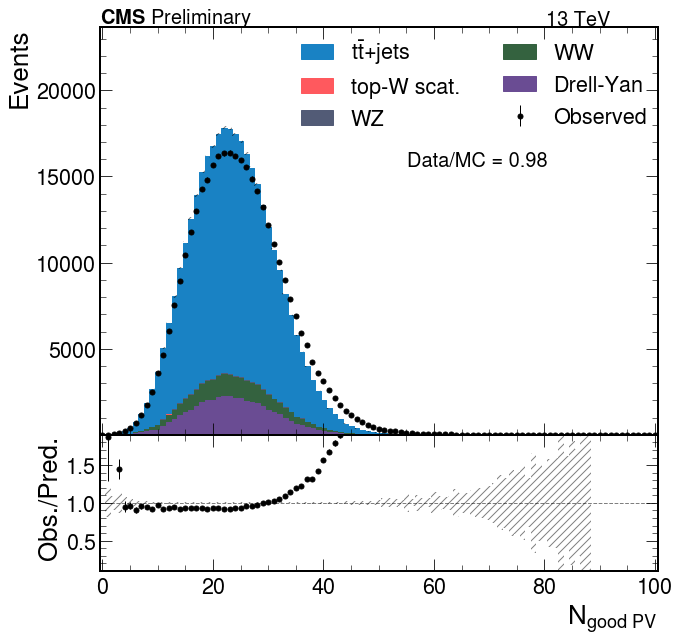

In [9]:
makePlot(output, 'PV_npvsGood', 'multiplicity',
         #data_sel=None,
         bins=None, log=False, normalize=True, axis_label=r'$N_{good\ PV}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


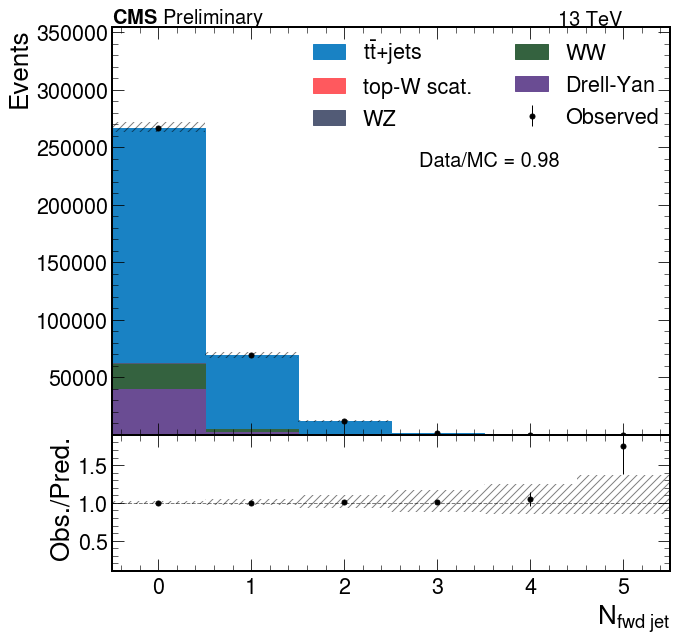

In [25]:
makePlot(output, 'N_fwd', 'multiplicity',
         #data_sel=None,
         bins=N_bins_red, log=False, normalize=True, axis_label=r'$N_{fwd\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


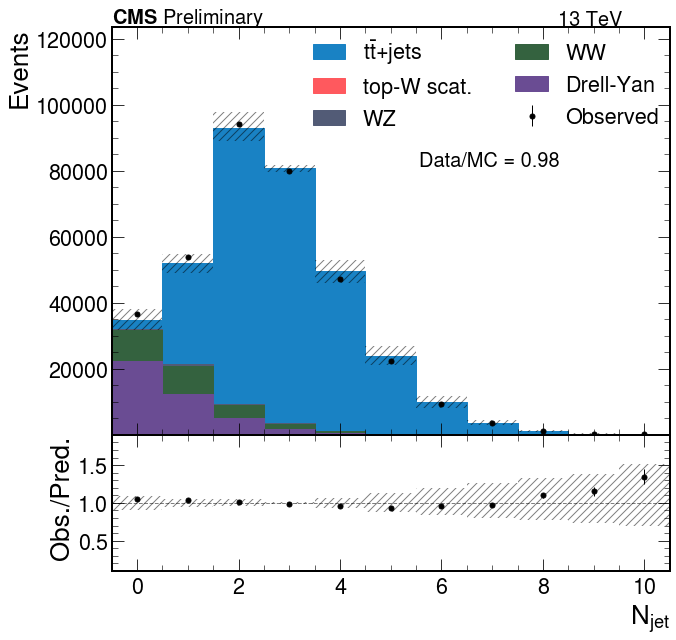

In [26]:
makePlot(output, 'N_jet', 'multiplicity',
         #data_sel=None,
         bins=N_bins, log=False, normalize=True, axis_label=r'$N_{jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


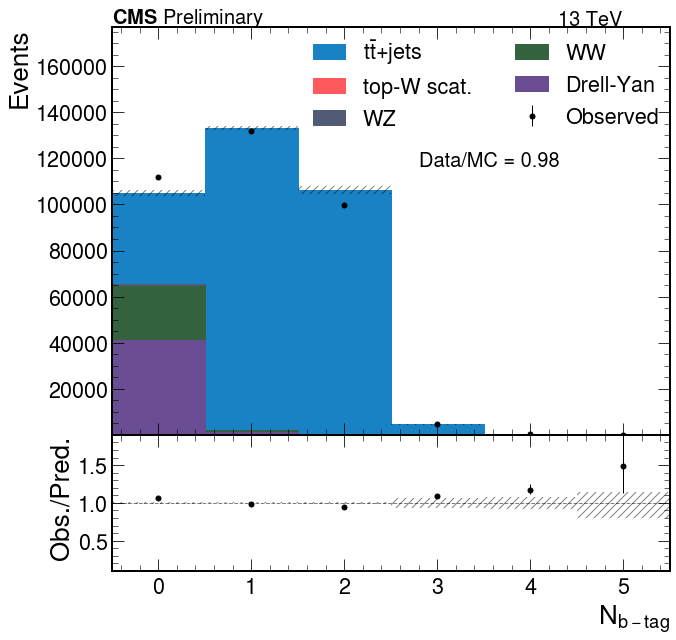

In [27]:
makePlot(output, 'N_b', 'multiplicity',
         #data_sel=None,
         bins=N_bins_red, log=False, normalize=True, axis_label=r'$N_{b-tag}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


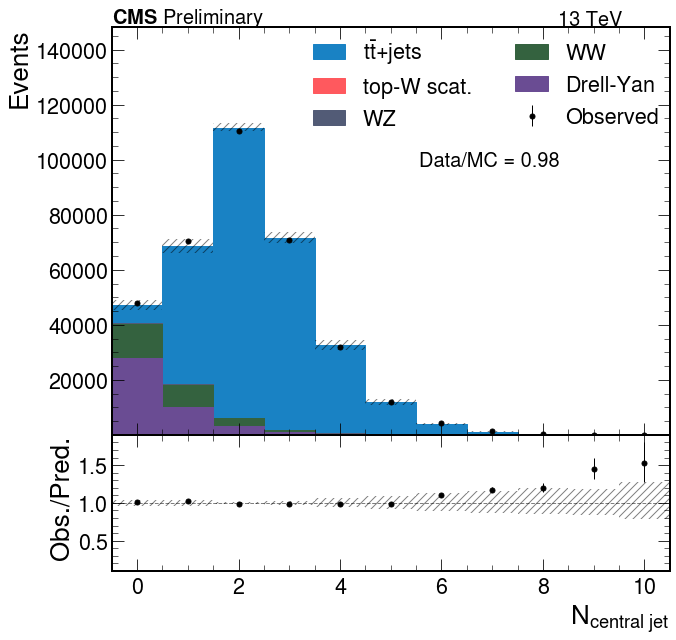

In [28]:
makePlot(output, 'N_central', 'multiplicity',
         #data_sel=None,
         bins=N_bins, log=False, normalize=True, axis_label=r'$N_{central\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


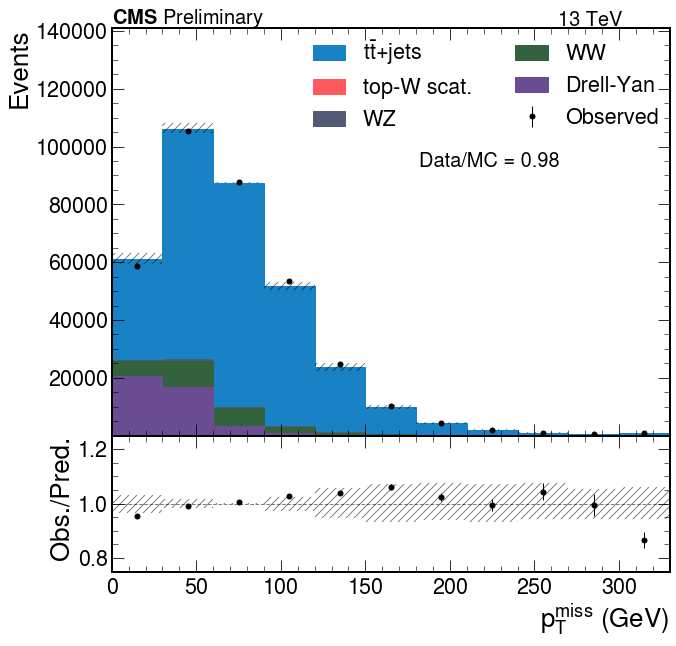

In [29]:
makePlot(output, 'MET', 'pt',
         #data_sel=None,
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_{T}^{miss}\ (GeV)$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         ratio_range = (0.75,1.25)
        )

Data: 20145.0 MC: 21790.61
Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst_v2


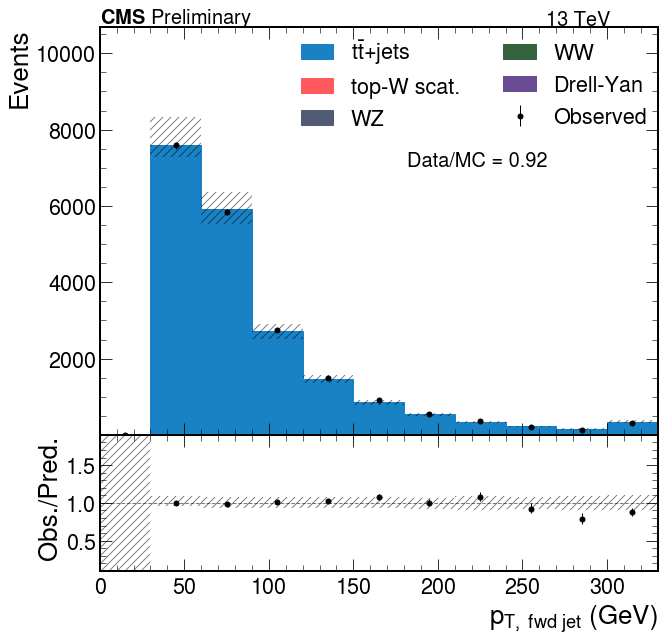

In [30]:
makePlot(output, 'fwd_jet', 'pt',
         #data_sel=None,
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_{T,\ fwd\ jet}$ (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst_v2'
        )

Central: 21391.035863161655
Up: 23140.084144556076
Down: 20128.729675480376


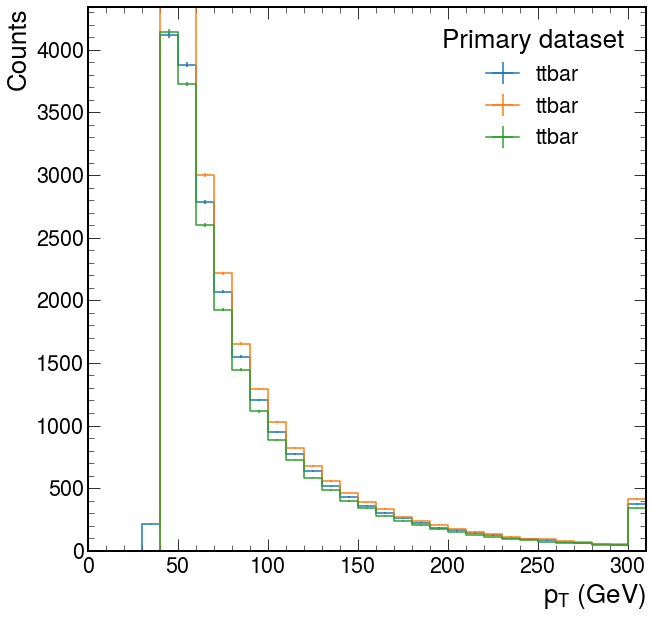

In [31]:
jet_name = 'fwd_jet'
sample_name = 'ttbar'

histogram = output[jet_name].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Central:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))

histogram = output[jet_name+'_pt_jesTotalUp'].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Up:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))

histogram = output[jet_name+'_pt_jesTotalDown'].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Down:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))



Data: 20145.0 MC: 21790.61


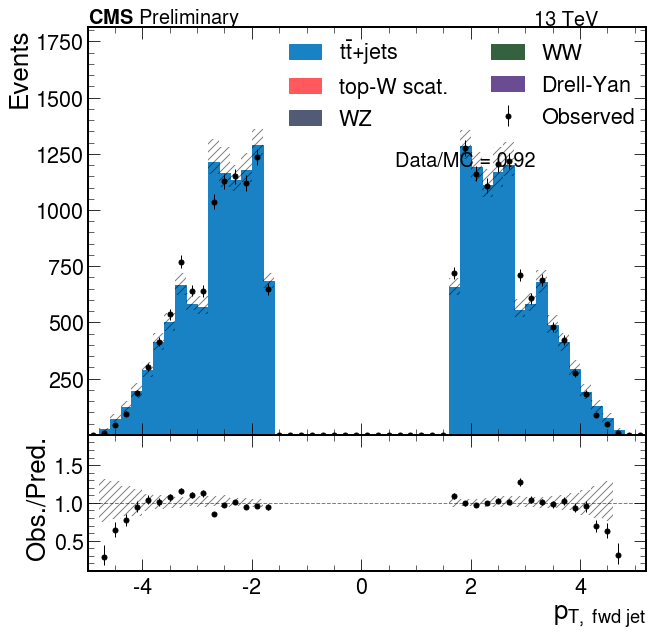

In [32]:
makePlot(output, 'fwd_jet', 'eta',
         #data_sel=None,
         bins=eta_bins, log=False, normalize=True, axis_label=r'$p_{T,\ fwd\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


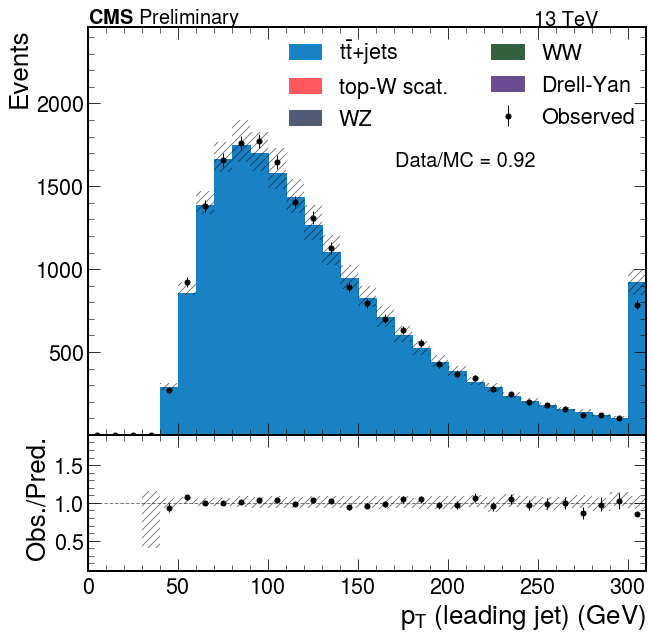

In [33]:
makePlot(output, 'j1', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading jet) (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


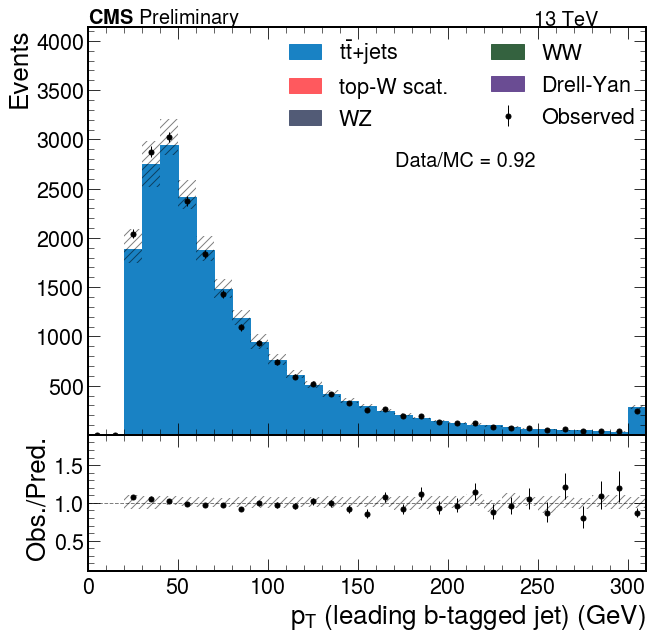

In [34]:
makePlot(output, 'b1', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading b-tagged jet) (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


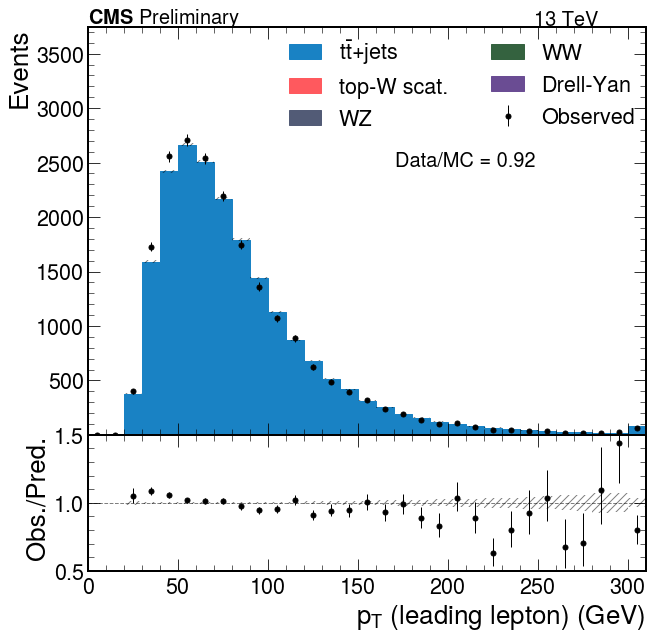

In [35]:
makePlot(output, 'lead_lep', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading lepton) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


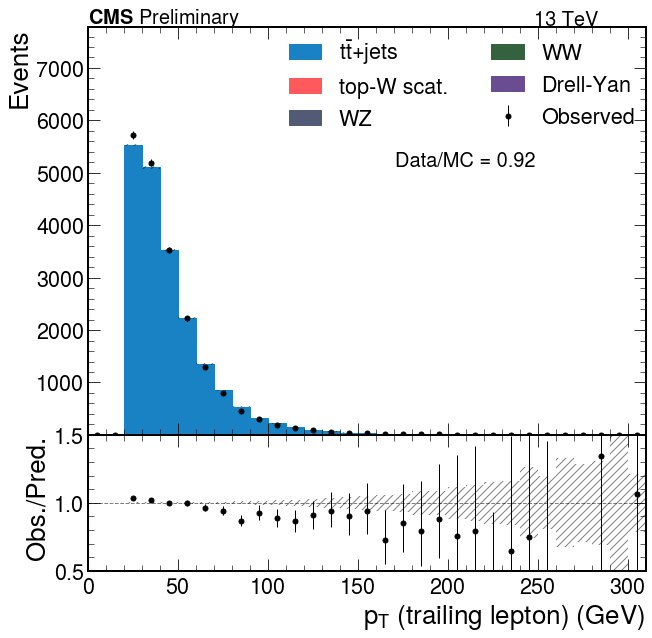

In [36]:
makePlot(output, 'trail_lep', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (trailing lepton) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


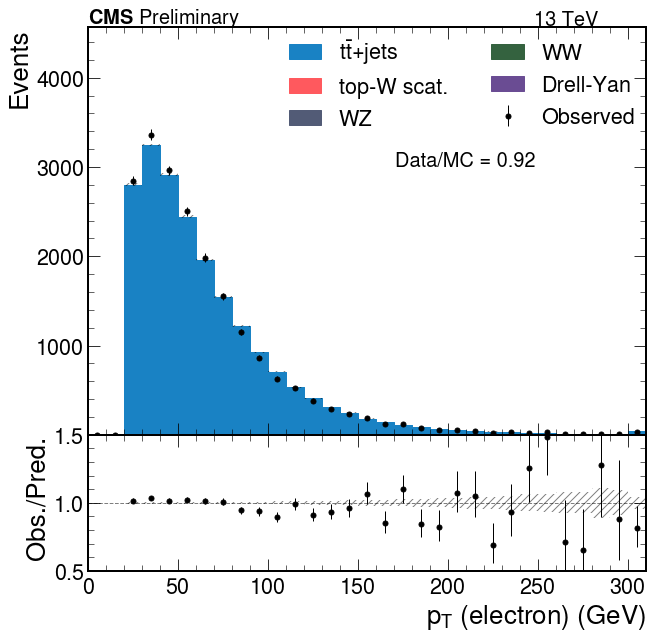

In [37]:
makePlot(output, 'electron', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (electron) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


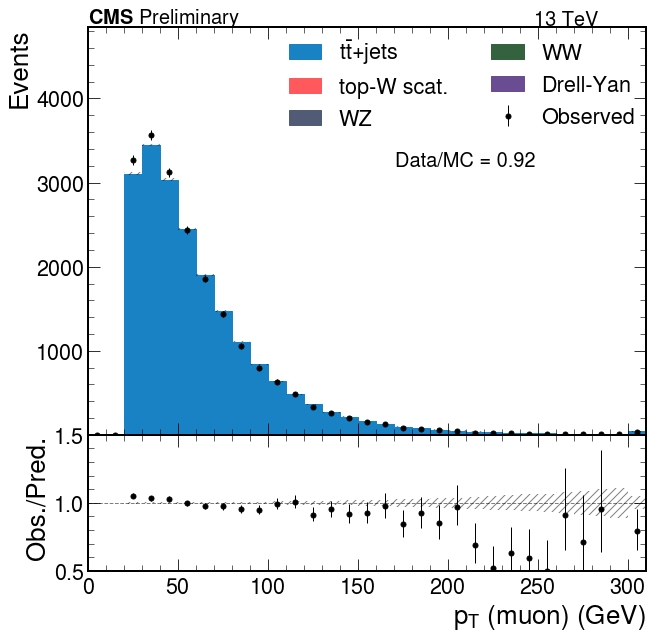

In [38]:
makePlot(output, 'muon', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (muon) (GeV)',
         ratio_range = (0.5,1.5)
         )

It seems like either we have a wrong normalization of ttbar, missing data events, or the lepton SFs are huge (and the PU reweighting also contributes much).

With ttH lepton IDs this is the normalization:

Data: 20146.0 MC: 28085.86

Looser SS ID:

Data: 26242.0 MC: 34977.04

There's some missing 0b simulation, potentially W+jets with a fake?

Let's implement the proper lepton SFs and then see, SFs around 0.9 will already bring data/MC to agreement.

# Some development stuff

In [4]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# the below command will change to .from_root in coffea v0.7.0
events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/tW_scattering_nanoAOD/nanoSkim_1.root', schemaclass=NanoAODSchema).events()

In [5]:
weight = Weights(len(events))
#weight.weight()

In [6]:
import uproot4
#fin = uproot4.open('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/tW_scattering_nanoAOD/nanoSkim_1.root')
fin = uproot4.open('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/nanoAOD_37_Skim.root')

In [7]:
#fin['Events'].show() # this shows all the branches

In [8]:
from coffea.btag_tools import BTagScaleFactor

In [9]:
btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/Tools/data/btag/DeepJet_102XSF_V2.csv"), "medium")

print("SF:", btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))
print("systematic +:", btag_sf.eval("up", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))

SF: [[1.29, 1.38, 1.51, 0.984, 1.52, 1.52, ... 1.52, 1.52, 0.994, 1.52, 0.994, 1.52]]
systematic +: [[1.54, 1.63, 1.75, 0.998, 1.75, 1.75, 1.06, ... 1.74, 1.74, 1.19, 1.74, 1.06, 1.74]]


In [10]:
sf = btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt, )
len(sf)

25315

In [20]:
        ev = events
        ## Muons
        muon     = Collections(ev, "Muon", "tightTTH").get()
        vetomuon = Collections(ev, "Muon", "vetoTTH").get()
        dimuon   = choose(muon, 2)
        SSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)>0, axis=1)
        OSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)<0, axis=1)
        leading_muon_idx = ak.singletons(ak.argmax(muon.pt, axis=1))
        leading_muon = muon[leading_muon_idx]
        
        ## Electrons
        electron     = Collections(ev, "Electron", "tightTTH").get()
        vetoelectron = Collections(ev, "Electron", "vetoTTH").get()
        dielectron   = choose(electron, 2)
        SSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)>0, axis=1)
        OSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)<0, axis=1)
        leading_electron_idx = ak.singletons(ak.argmax(electron.pt, axis=1))
        leading_electron = electron[leading_electron_idx]
        
        ## Merge electrons and muons - this should work better now in ak1
        lepton   = ak.concatenate([muon, electron], axis=1)
        dilepton = cross(muon, electron)
        SSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)>0, axis=1)
        OSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)<0, axis=1)
        leading_lepton_idx = ak.singletons(ak.argmax(lepton.pt, axis=1))
        leading_lepton = lepton[leading_lepton_idx]
        trailing_lepton_idx = ak.singletons(ak.argmin(lepton.pt, axis=1))
        trailing_lepton = lepton[trailing_lepton_idx]

In [38]:
selection = ((ak.num(electron) + ak.num(muon))==2)

ak.to_numpy(ak.flatten(leading_lepton[selection].pt))

array([127.076775,  96.17632 , 103.22386 ,  38.435608,  33.92872 ,
        61.140045,  90.60478 ,  39.29859 , 108.46329 ,  79.80157 ,
       126.51279 ,  77.26335 , 192.73763 , 148.70555 ,  55.059555,
       137.83707 ,  37.19563 ,  60.521458,  56.741486, 105.11551 ,
        73.54765 ,  44.736988, 225.69763 , 144.86429 ,  82.8668  ,
        44.80729 ,  66.56819 ,  94.25571 ,  68.82681 ,  34.128735,
        68.311554,  83.521675,  72.75266 , 167.71571 , 106.35246 ,
        80.22213 , 238.52428 ,  75.913376, 119.99922 ,  98.25242 ,
        59.49584 , 184.49687 , 129.19702 ,  49.341827,  41.503616,
       124.128746, 167.67902 ], dtype=float32)

In [87]:
electron = Collections(events, "Electron", "tight", verbose=True).get()
#muon = Collections(events, "Muon", "tight").get()

## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0

 - tight electron MVA ID
 - custom multi isolation
 - trigger safe


In [76]:
def getPtEtaPhi(coll, pt_var='pt', eta_var='eta', phi_var='phi'):
    #pt = 
    return ak.zip({'pt': getattr(coll, pt_var), 'eta': getattr(coll, eta_var), 'phi': getattr(coll, phi_var)})

In [11]:
jet = getJets(events)
jet.pt

<Array [[366, 218, 57.2, ... 52.3, 34.4, 25.2]] type='25315 * var * float32[para...'>